In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# first define system dimensionality and a target energy/distribution

dim = 2

from bgflow import MuellerPotential
target = MuellerPotential(dim, yshift=.65)
plot_range=[-1.5,1.5]

# # uncomment to try another simple 2D potential
# from bgflow import WolfeQuappLike
# target = WolfeQuappLike(dim)
# plot_range=[-3,3]


In [4]:
# define some plotting functions

from bgflow.utils.types import assert_numpy


def plot_energy(energy, extent=(plot_range[0], plot_range[1]), resolution=100, dim=2, delta=15):
    """ Plot energy functions in 2D """
    xs = torch.meshgrid([torch.linspace(*extent, resolution) for _ in range(2)])
    xs = torch.stack(xs, dim=-1).view(-1, 2)
    xs = torch.cat([
        xs,
        torch.Tensor(xs.shape[0], dim - xs.shape[-1]).zero_()
    ], dim=-1)
    us = energy.energy(xs).view(resolution, resolution)
   # us = torch.exp(-us)
    reference=float(torch.min(us))
    plt.imshow(assert_numpy(us).T, extent=extent * 2, origin='lower', vmin=reference, vmax=reference+delta)
    plt.xlim(extent)
    plt.ylim(extent)


def plot_samples(samples, weights=None, range=None):
    """ Plot sample histogram in 2D """
    samples = assert_numpy(samples)
    plt.hist2d(
        samples[:, 0], 
        samples[:, 1],
        weights=assert_numpy(weights) if weights is not None else weights,
        bins=100,
        density=True,
        norm=mpl.colors.LogNorm(),
        cmap='viridis_r',
        range=range
    )
    
def plot_bg(bg, target, n_samples=10000, range=plot_range, dim=2):
    """ Plot target energy, bg energy and bg sample histogram"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plot_energy(target, extent=range, dim=dim)
    plt.title("Target energy")
    plt.subplot(1, 3, 2)
    plot_energy(bg, extent=range, dim=dim)
    plt.title("BG energy")
    plt.subplot(1, 3, 3)
    plot_samples(bg.sample(n_samples), range=[range, range])
    plt.title("BG samples")

def plot_weighted_energy_estimate(bg, target, n_samples=100000, extent=None, n_bins=100, range=plot_range, dim=dim, delta=25):
    """ Plot weighed energy from samples """
    samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True)
    log_weights = bg.log_weights_given_latent(samples, latent, dlogp)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    bins = torch.linspace(*range, n_bins).view(-1, 1)
    fesx=np.zeros(n_bins)
    for i in np.arange(n_bins):
        xs = torch.cat([torch.zeros(bins.shape[0], dim - 1)+bins[i], bins], dim=-1).view(-1, dim)
        ene=assert_numpy(target.energy(xs).view(-1))
        fesx[i]=-np.log(np.trapz(np.exp(-ene)))
    fesx-=fesx.min()
    hist,_=np.histogram(assert_numpy(samples[:, 0]),bins=n_bins,range=(range[0],range[1]))
    fesx_estimate=-np.log(np.where(hist!=0,hist/hist.max(),np.nan))

    plt.plot(bins, fesx_estimate, label="estimated FES") 
    plt.plot(bins, fesx, '--', label="target FES")
    plt.ylim([0,delta])
    plt.xlabel("$x0$")
    plt.ylabel("log density")
    plt.legend()
    plt.title("unweighed Free Energy Surface")
    
    plt.subplot(1, 3, 2)
    hist,_=np.histogram(assert_numpy(samples[:, 0]),bins=n_bins,range=(range[0],range[1]),weights=assert_numpy(log_weights.exp()))
    fesx_estimate=-np.log(np.where(hist!=0,hist/hist.max(),np.nan))
    plt.plot(bins, fesx_estimate, label="estimated FES")
    plt.plot(bins, fesx, '--', label="target FES")
    plt.ylim([0,delta])
    plt.xlabel("$x0$")
    plt.legend()
    plt.title("weighed Free Energy Surface")

    plt.subplot(1, 3, 3)
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plot_samples(samples, weights=log_weights.exp(), range=[range, range])
    plt.title("weighed samples")
    
    plt.show()
    print('BG sampling efficiency: {:.2%}'.format(bg.sampling_efficiency(log_weights)))

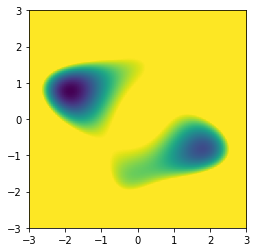

In [5]:
# plot target energy
plot_energy(target, dim=dim)

In [6]:
# define a MCMC sampler to sample from the target energy

from bgflow import GaussianMCMCSampler

init_state = torch.Tensor([[-0.5, 0.6], [0.6, -0.7]])
init_state = torch.cat([init_state, torch.Tensor(init_state.shape[0], dim-2).normal_()], dim=-1)
target_sampler = GaussianMCMCSampler(target, init_state=init_state)

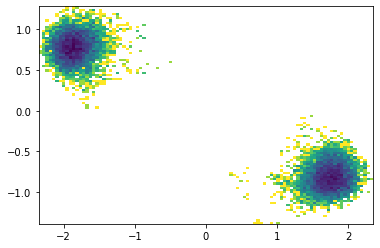

In [7]:
# sample some data 

data = target_sampler.sample(10000)

plot_samples(data)

In [8]:
# now set up a prior

from bgflow import NormalDistribution

shift_mean=torch.tensor([1.7,1.7]) #the mean is shifted to make it slightly more challenging
prior = NormalDistribution(dim,mean=shift_mean)

In [9]:
# define a flow with RNVP coupling layers

from bgflow.nn import (
    DenseNet,
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow, 
    InverseFlow, 
    SwapFlow,
    AffineTransformer
)


# here we aggregate all layers of the flow
layers = []

# start with a splitting layer which splits the input tensor into two 
# flow channels with tensors of half dimensionality
layers.append(SplitFlow(dim // 2))


# now add coupling layers
n_coupling_layers = 4
for _ in range(n_coupling_layers):
    
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        # we use a affine transformation to transform the RHS conditioned on the LHS
        AffineTransformer(
            # use simple dense nets for the affine shift/scale
            shift_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU()), 
            scale_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU())
        )
    ))
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow(dim // 2)))
    
# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers)

In [10]:
# having a flow and a prior, we can now define a Boltzmann Generator

from bgflow import BoltzmannGenerator

bg = BoltzmannGenerator(prior, flow, target)

Automatic pdb calling has been turned ON


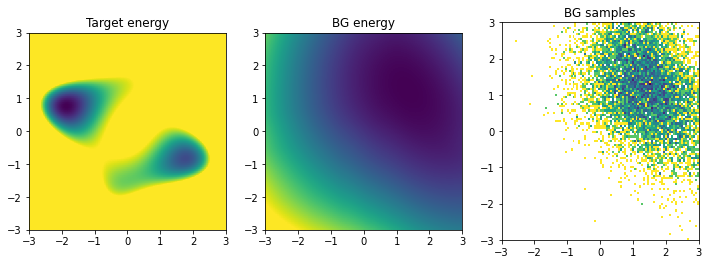

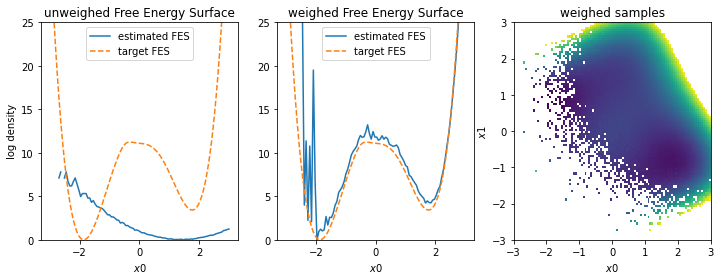

BG sampling efficiency: 0.02%


In [11]:
# initial bg should not be useful
%pdb
plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target)

In [12]:
from bgflow.utils.types import is_list_or_tuple

class LossReporter:
    """
        Simple reporter use for reporting losses and plotting them.
    """
    
    def __init__(self, *labels):
        self._labels = labels
        self._n_reported = len(labels)
        self._raw = [[] for _ in range(self._n_reported)]
    
    def report(self, *losses):
        assert len(losses) == self._n_reported
        for i in range(self._n_reported):
            self._raw[i].append(assert_numpy(losses[i]))
    
    def plot(self, n_smooth=10):
        fig, axes = plt.subplots(self._n_reported, sharex=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        fig.set_size_inches((8, 4 * self._n_reported), forward=True)
        for i, (label, raw, axis) in enumerate(zip(self._labels, self._raw, axes)):
            raw = assert_numpy(raw).reshape(-1)
            kernel = np.ones(shape=(n_smooth,)) / n_smooth
            smoothed = np.convolve(raw, kernel, mode="valid")
            axis.plot(smoothed)
            axis.set_ylabel(label)
            if i == self._n_reported - 1:
                axis.set_xlabel("Iteration")
                
    def recent(self, n_recent=1):
        return np.array([raw[-n_recent:] for raw in self._raw])

In [13]:
# initial training with likelihood maximization on data set

from bgflow.utils.train import IndexBatchIterator

n_batch = 32
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 5
n_report_steps = 50

reporter = LossReporter("NLL")

In [14]:

for epoch in range(n_epochs):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs]
        
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        nll.backward()
        
        reporter.report(nll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, NLL: {3:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    *reporter.recent(1).ravel()
                ), end="")
        

epoch: 4, iter: 600/625, NLL: 0.0391139

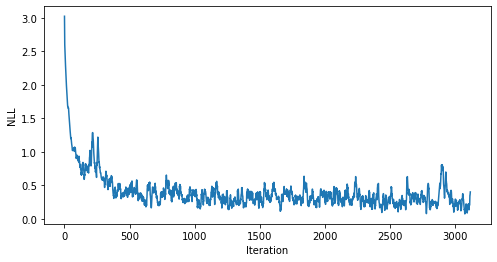

In [15]:
reporter.plot()

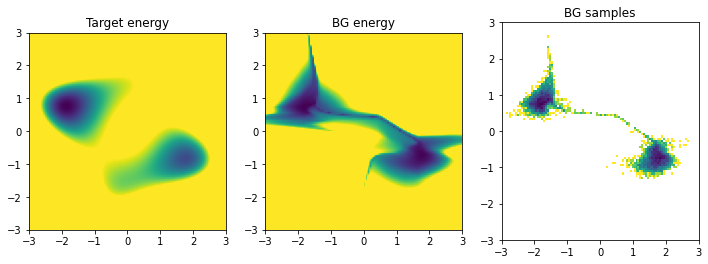

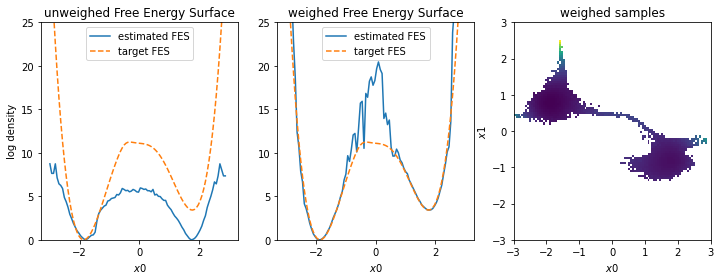

BG sampling efficiency: 35.16%


In [16]:
# bg after ML training

plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target, dim=dim)

In [17]:
# train with convex mixture of NLL and KL loss

from bgflow.utils.train import IndexBatchIterator

n_kl_samples = 128
n_batch = 128
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 5
n_report_steps = 50

# mixing parameter
lambdas = torch.linspace(1., 0.5, n_epochs)

reporter = LossReporter("NLL", "KLL")

In [18]:
lambdas

tensor([1.0000, 0.8750, 0.7500, 0.6250, 0.5000])

In [19]:

for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs]
        
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        
        # aggregate weighted gradient
        (lamb * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples).mean()

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")

epoch: 4, iter: 150/156, lambda: 0.5, NLL: 0.2762, KLL: 4.483679

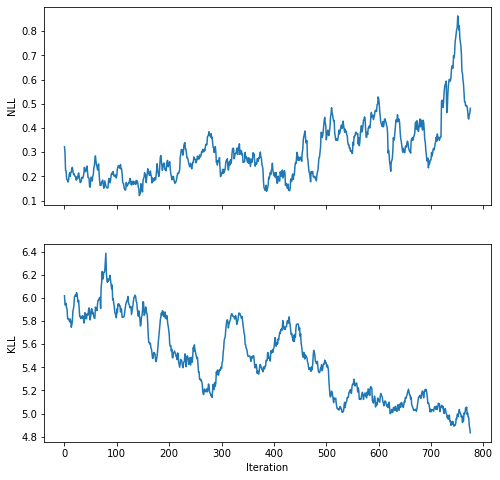

In [20]:
reporter.plot()

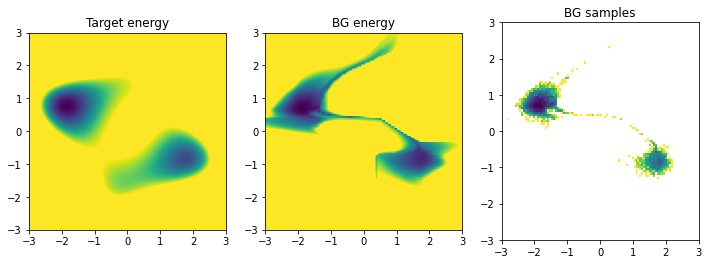

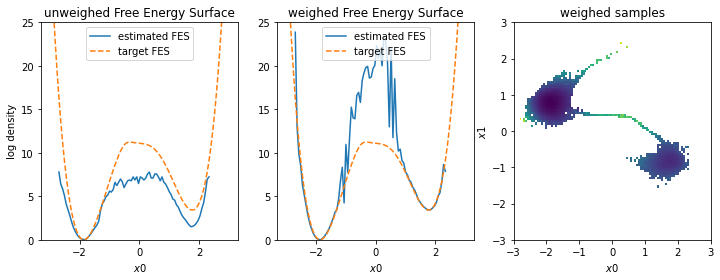

BG sampling efficiency: 55.93%


In [21]:
# bg after ML + KL training

plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target, dim=dim)